## Setup environment

In [1]:
import os
import json
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
config_file = 'config.json'

with open(config_file, 'r') as f:
    config = json.load(f)

log_dir = config["log_dir"]

fdg_data_dir = config["fdg_data_dir"]
fdg_output_dir = config['fdg_output_dir']

ga_output_dir = config["ga_output_dir"]
ga_data_dir = config["ga_data_dir"]

artifact_dir = config["artifacts"]
artifact_output_dir = config ["artifact_output_dir"]

artifact_repeated_dir = config["artifact_repeated_dir"]
artifacts_repeated_output_dir = config["artifacts_repeated_output_dir"]




## Set dataset path

------
# FDG

In [ ]:

from data_preparation import ExternalRadioSetHandling

data_handler = ExternalRadioSetHandling(data_dir=fdg_data_dir, test_ratio=0.2)
train, valid, test_files = data_handler.get_split_data()

print(f"Test data length: {len(test_files)}")

# To access 'image' keys, iterate through the list
image_files = [file_info['image'] for file_info in test_files]
target_files = [file_info['target'] for file_info in test_files]
print(len(image_files))

-------------
# Ga

In [ ]:

from data_preparation import DataHandling 

data_handler = DataHandling(ga_data_dir, train_mode="NAC", target_mode="MAC")

train_files = data_handler.get_data_split('train')
val_files = data_handler.get_data_split('val')
test_files = data_handler.get_data_split('test')
print(len(train_files))
print(len(val_files))
print(len(test_files))

from data_preparation import LoaderFactory
loader_factory = LoaderFactory(
    train_files=None,
    val_files=None,
    test_files=test_files,
    patch_size = [168, 168, 16],
    spacing = [4.07, 4.07, 3.00],
    # spacing = [1.92, 1.92, 3.27], # For fdg data
    spatial_size = (168, 168, 400)
    # spatial_size = (336, 336, 640) # for Fdg data
    )

test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)

--------
# Ga-Artifact

In [3]:
from data_preparation import ExternalRadioSetHandling

data_handler = ExternalRadioSetHandling(data_dir=artifact_dir, test_ratio=1)
_, _, test_files = data_handler.get_split_data()

print(f"Test data length: {len(test_files)}")

# To access 'image' keys, iterate through the list
image_files = [file_info['image'] for file_info in test_files]
target_files = [file_info['target'] for file_info in test_files]
print(len(image_files))

Test data length: 60
60


----------

In [4]:
test_name = [(os.path.splitext(os.path.splitext(os.path.basename(file_info['image']))[0])[0], 
              os.path.splitext(os.path.splitext(os.path.basename(file_info['target']))[0])[0]) 
             for file_info in test_files]
test_name

[('001040_C1_RZ_', '001040_C1_RZ_'),
 ('001651_C1_RZ_', '001651_C1_RZ_'),
 ('004178_C4_SH_', '004178_C4_SH_'),
 ('007022_C5_RJ_', '007022_C5_RJ_'),
 ('002406_C2_IM_', '002406_C2_IM_'),
 ('007056_C5_RJ_', '007056_C5_RJ_'),
 ('004074_C4_SH_', '004074_C4_SH_'),
 ('007027_C5_RJ_', '007027_C5_RJ_'),
 ('002405_C2_IM_', '002405_C2_IM_'),
 ('007068_C5_RJ_', '007068_C5_RJ_'),
 ('007023_C5_RJ_', '007023_C5_RJ_'),
 ('007029_C5_RJ_', '007029_C5_RJ_'),
 ('004070_C4_SH_', '004070_C4_SH_'),
 ('001626_C1_RZ_', '001626_C1_RZ_'),
 ('007048_C5_RJ_', '007048_C5_RJ_'),
 ('003147_C3_KH_', '003147_C3_KH_'),
 ('001663_C1_RZ_', '001663_C1_RZ_'),
 ('001653_C1_RZ_', '001653_C1_RZ_'),
 ('004288_C4_SH_', '004288_C4_SH_'),
 ('001650_C1_RZ_', '001650_C1_RZ_'),
 ('007012_C5_RJ_', '007012_C5_RJ_'),
 ('003229_C3_KH_', '003229_C3_KH_'),
 ('004144_C4_SH_', '004144_C4_SH_'),
 ('007070_C5_RJ_', '007070_C5_RJ_'),
 ('003306_C3_KH_', '003306_C3_KH_'),
 ('007064_C5_RJ_', '007064_C5_RJ_'),
 ('003014_C3_KH_', '003014_C3_KH_'),
 

---------
# Corrected Artifactual Images

In [ ]:
from data_preparation import LoaderFactory

loader_factory = LoaderFactory(
    train_files=_,
    val_files=_,
    test_files=test_files,
    patch_size = [168, 168, 16],
    spacing = [4.07, 4.07, 3.00],
    spatial_size = (168, 168, 600) 
    )


test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)


In [ ]:
log_filename = 'log_4_17_19_29.txt'  # Ga, new structure. editesh kardam payini ro ezaf kardam behesh.

bestmodel_filename =  'model_4_24_23_17.pth'
best_metric = 0.0527
best_epoch = 434

In [ ]:
import os
import torch
from model_maker import get_network, add_activation_before_output
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_network(patch_size = [168, 168, 16], spacing = [4.07, 4.07, 3.00])

model = model.to(device)

add_activation_before_output(model, nn.ReLU(inplace=True))
model

In [ ]:
import torch

# Assuming root_dir is the directory where your model files are stored
model_path = os.path.join(log_dir, bestmodel_filename)
if os.path.exists(model_path):
    print(f"Model file {bestmodel_filename} is loading.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model file {bestmodel_filename} not found.")

In [ ]:

from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt
import numpy as np
from monai.transforms import Compose, Invertd, SaveImaged
from monai.data import decollate_batch


roi_size = (168, 168, 16)
sw_batch_size = 64


post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=loader_factory.get_test_transforms(),
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        # ClampNegative(keys=["pred"]),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=artifacts_repeated_output_dir, output_postfix="dl4_23", resample=False), 
    ]
)
# comb_3_27_onfdg_v2 fdg_output_dir
# dl4_23 ga_output_dir
# comb_4_5_onfdg fdg_output_dir

with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model, overlap=0.90)
        post_processed = [post_transforms(i) for i in decollate_batch(test_data)]



-----------------
# Now, It's time to evaluate!

In [ ]:
# from matplotlib.colors import LinearSegmentedColormap
# def display_patient_transverse(patient_folder_name, image, target, dl_image, difference_image, n, cmp="gray"):
#     """
#     Display medical images for a patient: input, target, deep learning output, and the difference.
#     """
#     colors = [(0.00, "red"), (0.40, "white"), (0.8, "white"), (1.00, "blue")]
#     cmap_name = 'custom_seismic_more_white'
#     cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=12)

#     fig, axs = plt.subplots(1, 4, figsize=(4, 2), gridspec_kw={'wspace':0, 'hspace':0})

#     # Turn off axes
#     for ax in axs:
#         ax.axis('off')

#     # Configure vmin and vmax for each image type
#     nac_display_range = (np.percentile(image, 0), np.percentile(image, 99.7))
#     mac_display_range = (np.percentile(target, 0), np.percentile(target, 99.7))
#     dl_display_range = (np.percentile(dl_image, 0), np.percentile(dl_image, 99.7))

#     # Input Image

#     input_slice = np.flipud(np.rot90(image[:, :, n]))
#     axs[0].imshow(input_slice, cmap=cmp, vmin=nac_display_range[0], vmax=nac_display_range[1])

#     # Target Image
#     axs[1].set_title(patient_folder_name)
#     target_slice = np.flipud(np.rot90(target[:, :, n]))
#     axs[1].imshow(target_slice, cmap=cmp, vmin=mac_display_range[0], vmax=mac_display_range[1])

#     # DL Image
 
#     dl_slice = np.flipud(np.rot90(dl_image[:, :, n]))
#     axs[2].imshow(dl_slice, cmap=cmp, vmin=dl_display_range[0], vmax=dl_display_range[1])

#     # Difference Image

#     difference_slice = np.flipud(np.rot90(difference_image[:, :, n]))
#     axs[3].imshow(difference_slice, cmap=cm, vmin=-1, vmax=1)

#     plt.show()




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def display_patient_transverse(patient_folder_name, image, target, dl_image, difference_image, n, cmp="gray"):
    """
    Display medical images for a patient: input, target, deep learning output, and the difference,
    zooming into the central part of the images without altering the figure size or image aspect ratio.
    """
    colors = [(0.00, "pink"), (0.40, "white"), (0.8, "white"), (1.00, "blue")]
    cmap_name = 'custom_seismic_more_white'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=12)
    nac_display_range = (np.percentile(image, 0), np.percentile(image, 99.5))
    mac_display_range = (np.percentile(target, 0), np.percentile(target, 99.5))
    dl_display_range = (np.percentile(dl_image, 0), np.percentile(dl_image, 100))
    difference_display_range = (-1, 1)

    fig, axs = plt.subplots(1, 4, figsize=(4, 2), gridspec_kw={'wspace':0, 'hspace':0})

    # Turn off axes
    for ax in axs:
        ax.axis('off')

    # Calculate the zoom factor
    zoom_factor = 3  # Defines how much of the center to show; 2 means showing 1/2 of the width and height

    # Configure each image display
    slices = [image, target, dl_image, difference_image]
    ranges = [nac_display_range, mac_display_range, dl_display_range, difference_display_range]
    for idx, (ax, slice_data, range) in enumerate(zip(axs, slices, ranges)):
        slice_rotated = np.rot90(slice_data[:, :, n])

        # Get dimensions
        height, width = slice_rotated.shape

        # Set limits to zoom into the middle of the image
        ax.set_xlim(width / 2 - width / zoom_factor, width / 2 + width / zoom_factor)
        ax.set_ylim(height / 2 - height / zoom_factor, height / 2 + height / zoom_factor)

        # Plot
        ax.imshow(slice_rotated, cmap=(cm if idx == 3 else cmp), vmin=range[0], vmax=range[1])

    plt.title(patient_folder_name)
    plt.tight_layout()
    plt.show()




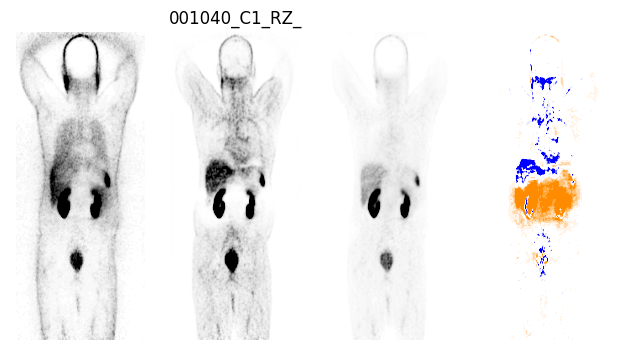

In [5]:
from utils import find_dl_image_path, normalize_data
from vis import display_patient_coronal


hint = "dl_final_3_29"
hint = 'gamodel_3_18_onfdg'
hint = 'dl4_23'
# hint = 'final_4_26'
# hint = 'comb_4_5_onfdg'
nac_factor=2
mac_factor=5

i = 1
for file_info, name_pair in zip(test_files, test_name):
    image_path = file_info['image']
    target_path = file_info['target']
    patient_folder_name_image, _ = name_pair

    dl_image_path = find_dl_image_path(artifact_output_dir, patient_folder_name_image, hint)
    if dl_image_path is None:
        print(f"No DL image found for {patient_folder_name_image}")
        continue

    # image = normalize_data(nib.load(image_path).get_fdata())
    # target = normalize_data(nib.load(target_path).get_fdata())
    # dl_image = normalize_data(nib.load(dl_image_path).get_fdata())

    image = (nib.load(image_path).get_fdata()) * nac_factor
    target = (nib.load(target_path).get_fdata()) * mac_factor
    dl_image = (nib.load(dl_image_path).get_fdata()) * mac_factor
    difference_image = (target - dl_image) / mac_factor
    # print(np.max(difference_image), np.min(difference_image))
    difference_image = np.clip(difference_image, -1, 1)

    
    n = 101
    n = 85
    
    # n = 85
    # n = 90
    # n = 108
    # n = 100
    # n = 125
    
    display_patient_coronal(patient_folder_name_image, image, target, dl_image, difference_image, n, cmp ="gist_yarg")
    i +=1
    if i == 2:
        break

    # n = 117
    # n = 198
    # n = 74
    # n = 52
    # n = 62
    # n = 48
    # n = 97

    # display_patient_transverse(patient_folder_name_image, image, target, dl_image, difference_image, n, cmp ="gist_yarg")
    # # # i +=1
    # # # if i == 4:
    # # #     break
    
# vmin=0, vmax=0.5, vmin=0, vmax=5

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
def display_patient_coronal(patient_folder_name, image, target, dl_image, difference_image, n, cmp="gray"):
    """
    Display medical images for a patient: input, target, deep learning output, and the difference.
    """
    colors = [(0.00, "orange"), (0.40, "white"), (0.8, "white"), (1.00, "blue")]
    cmap_name = 'custom_seismic_more_white'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=12)

    fig, axs = plt.subplots(1, 4, figsize=(8, 4), gridspec_kw={'wspace':0, 'hspace':0})

    # Turn off axes
    for ax in axs:
        ax.axis('off')

    # Configure vmin and vmax for each image type
    nac_display_range = (np.percentile(image, 0), np.percentile(image, 99.9))
    mac_display_range = (np.percentile(target, 0), np.percentile(target, 99.9))
    dl_display_range = (np.percentile(dl_image, 0), np.percentile(dl_image, 99.9))

    # Input Image

    input_slice = np.rot90(image[:, n, :])
    axs[0].imshow(input_slice, cmap=cmp, vmin=nac_display_range[0], vmax=nac_display_range[1])

    # Target Image
    axs[1].set_title(patient_folder_name)
    target_slice = np.rot90(target[:, n, :])
    axs[1].imshow(target_slice, cmap=cmp, vmin=mac_display_range[0], vmax=mac_display_range[1])

    # DL Image
 
    dl_slice = np.rot90(dl_image[:, n, ])
    axs[2].imshow(dl_slice, cmap=cmp, vmin=dl_display_range[0], vmax=dl_display_range[1])

    # Difference Image

    difference_slice = np.rot90(difference_image[:, n, :])
    axs[3].imshow(difference_slice, cmap=cm, vmin=-1, vmax=1)


    plt.show()


In [ ]:
# from matplotlib.colors import LinearSegmentedColormap
# import matplotlib.pyplot as plt
# import numpy as np

# def display_patient_coronal(patient_folder_name, image, target, dl_image, difference_image, n, cmp="gray"):
#     """
#     Display medical images for a patient: input, target, deep learning output, and the difference.
#     """
#     colors = [(0.00, "red"), (0.40, "white"), (0.80, "white"), (1.00, "blue")]
#     cmap_name = 'custom_seismic_more_white'
#     cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=12)

#     fig, axs = plt.subplots(1, 4, figsize=(12, 6), gridspec_kw={'wspace': 0, 'hspace': 0})
#     cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

#     # Turn off axes
#     for ax in axs:
#         ax.axis('off')

#     # Configure vmin and vmax for each image type
#     nac_display_range = (np.percentile(image, 0), np.percentile(image, 99.9))
#     mac_display_range = (np.percentile(target, 0), np.percentile(target, 99.9))
#     dl_display_range = (np.percentile(dl_image, 0), np.percentile(dl_image, 99.9))

#     # Input Image
#     input_slice = np.rot90(image[:, n, :])
#     im = axs[0].imshow(input_slice, cmap=cmp, vmin=nac_display_range[0], vmax=nac_display_range[1])

#     # Target Image
#     axs[1].set_title(patient_folder_name)
#     target_slice = np.rot90(target[:, n, :])
#     axs[1].imshow(target_slice, cmap=cmp, vmin=mac_display_range[0], vmax=mac_display_range[1])

#     # DL Image
#     dl_slice = np.rot90(dl_image[:, n, :])
#     axs[2].imshow(dl_slice, cmap=cmp, vmin=dl_display_range[0], vmax=dl_display_range[1])

#     # Difference Image
#     difference_slice = np.rot90(difference_image[:, n, :])
#     im_diff = axs[3].imshow(difference_slice, cmap=cm, vmin=-1, vmax=1)

#     # Add colorbars
#     fig.colorbar(im, ax=axs[0], orientation='vertical')
#     fig.colorbar(im, ax=axs[1], orientation='vertical')
#     fig.colorbar(im, ax=axs[2], orientation='vertical')
#     fig.colorbar(im_diff, ax=axs[3], orientation='vertical')

#     plt.show()


# n = 50

# display_patient_coronal(patient_folder_name, image, target, dl_image, difference_image, n)


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np

def display_patient_coronal(patient_folder_name, image, target, dl_image, difference_image, n, cmp="gray"):
    """
    Display medical images for a patient: input, target, deep learning output, and the difference.
    """
    colors = [(0.00, "orange"), (0.40, "white"), (0.8, "white"), (1.00, "blue")]
    cmap_name = 'custom_seismic_more_white'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=12)

    fig, axs = plt.subplots(1, 4, figsize=(12, 4), gridspec_kw={'wspace':0.3, 'hspace':0})

    # Turn off axes
    for ax in axs:
        ax.axis('off')

    # Configure vmin and vmax for each image type
    nac_display_range = (np.percentile(image, 0), np.percentile(image, 99.9))
    mac_display_range = (np.percentile(target, 0), np.percentile(target, 99.9))
    dl_display_range = (np.percentile(dl_image, 0), np.percentile(dl_image, 99.9))

    # Input Image
    input_slice = np.rot90(image[:, n, :])
    im0 = axs[0].imshow(input_slice, cmap=cmp, vmin=nac_display_range[0], vmax=nac_display_range[1])
    fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    # Target Image
    axs[1].set_title(patient_folder_name)
    target_slice = np.rot90(target[:, n, :])
    im1 = axs[1].imshow(target_slice, cmap=cmp, vmin=mac_display_range[0], vmax=mac_display_range[1])
    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    # DL Image
    dl_slice = np.rot90(dl_image[:, n, :])
    im2 = axs[2].imshow(dl_slice, cmap=cmp, vmin=dl_display_range[0], vmax=dl_display_range[1])
    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    # Difference Image
    difference_slice = np.rot90(difference_image[:, n, :])
    im3 = axs[3].imshow(difference_slice, cmap=cm, vmin=-1, vmax=1)
    fig.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)

    plt.show()



In [ ]:
from utils import find_dl_image_path, normalize_data
# from vis import display_patient_coronal


hint = "dl_final_3_29"
hint = 'gamodel_3_18_onfdg'
hint = 'dl4_23'
hint = 'adcm_4_26'
hint = "final_4_26"
hint = 'comb_4_5_onfdg'
nac_factor=3
mac_factor=7

i = 1
for file_info, name_pair in zip(test_files, test_name):
    image_path = file_info['image']
    target_path = file_info['target']
    patient_folder_name_image, _ = name_pair

    dl_image_path = find_dl_image_path(fdg_output_dir, patient_folder_name_image, hint)
    if dl_image_path is None:
        print(f"No DL image found for {patient_folder_name_image}")
        continue

    # image = normalize_data(nib.load(image_path).get_fdata())
    # target = normalize_data(nib.load(target_path).get_fdata())
    # dl_image = normalize_data(nib.load(dl_image_path).get_fdata())

    image = (nib.load(image_path).get_fdata()) * nac_factor
    target = (nib.load(target_path).get_fdata()) * mac_factor
    dl_image = (nib.load(dl_image_path).get_fdata()) * mac_factor
    difference_image = (target - dl_image) 
    # print(np.max(difference_image), np.min(difference_image))
    difference_image = np.clip(difference_image, -1, 1)


    n = 90
    # n = 85
    # n = 90
    # n = 108
    # n = 100
    # n = 115
    
    display_patient_coronal(patient_folder_name_image, image, target, dl_image, difference_image, n, cmp ="jet")
    # i +=1
    # if i == 20:
    #     break


In [ ]:
# import nibabel as nib
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# import glob
# from matplotlib.colors import LinearSegmentedColormap
# import numpy as np
# import matplotlib.pyplot as plt

# def apply_window(image, window_level, window_width):
#     """
#     Apply window level and width to an image.

#     Parameters:
#     - image: The input image as a NumPy array.
#     - window_level (WL): The center of the range of interest.
#     - window_width (WW): The width of the range of interest.

#     Returns:
#     - The windowed image.
#     """
#     lower_bound = window_level - window_width / 2
#     upper_bound = window_level + window_width / 2
#     windowed_image = np.clip(image, lower_bound, upper_bound)
#     windowed_image = (windowed_image - lower_bound) / window_width
#     return windowed_image

# window_level = 0  # Example values
# window_width = 1  # Example values

# hint = "dl3_18"

# # Function to find the DL image path for a given patient folder name
# def find_dl_image_path(patient_folder_name):
#     # Construct a glob pattern to search for DL images with the matching patient folder name
#     search_pattern = os.path.join(artifact_output, "**", f"{patient_folder_name}*{hint}.nii.gz")
#     found_paths = glob.glob(search_pattern, recursive=True)
#     if found_paths:
#         return found_paths[0]  # Return the first match
#     else:
#         return None  # No match found

# def normalize_data(data):
#     return (data - np.min(data)) / (np.max(data) - np.min(data))
# cmap = LinearSegmentedColormap.from_list(
#     'bwr', 
#     # ['purple', 'purple','darkviolet','white','white', 'lime', 'limegreen','limegreen']
#     ['purple','white','limegreen']
#     # ['purple', 'purple','purple','white','white', 'limegreen', 'limegreen','limegreen']
#     #['red', 'red','orangered','white','white', 'royalblue', 'blue','blue']
#     #['red', 'red','red','white','white', 'blue', 'blue','blue']
#     # ['red', 'red','red','tomato','white','white' , 'dodgerblue', 'blue', 'blue', 'blue']
# )
# # Loop over each file pair, find the matching DL image, and plot them
# for file_info, name_pair in zip(test_files, test_name):
#     image_path = file_info['image']
#     target_path = file_info['target']
#     patient_folder_name_image, _ = name_pair

#     dl_image_path = find_dl_image_path(patient_folder_name_image)
#     if dl_image_path is None:
#         print(f"No DL image found for {patient_folder_name_image}")
#         continue

#     # Load and normalize images
#     image = normalize_data(nib.load(image_path).get_fdata())
#     target = normalize_data(nib.load(target_path).get_fdata())
#     dl_image = normalize_data(nib.load(dl_image_path).get_fdata())
#     windowed_image = apply_window(image, window_level, window_width)
#     # Calculate the difference image and normalize to range -1 to 1
#     difference_image = target - dl_image
#     # difference_image = np.clip(difference_image, -1, 1)  # Ensure the difference is within -1 to 1

#     # difference_image = 2 * (difference_image - np.min(difference_image)) / (np.max(difference_image) - np.min(difference_image)) - 1

#     # image = nib.load(image_path).get_fdata()
#     # target = nib.load(target_path).get_fdata()
#     # dl_image = nib.load(dl_image_path).get_fdata()
#     # difference_image = target - dl_image
#     # # difference_image = np.clip(difference_image, -1, 1)  # Ensure the difference is within -1 to 1
#     n = 94

#     fig, axs = plt.subplots(1, 4, figsize=(20, 6))

#     plt.subplot(1, 4, 1)
#     plt.title(f"Input: {patient_folder_name_image}")
#     input_slice = np.rot90(image[:, n, :])
#     plt.imshow(input_slice, cmap="gist_yarg", vmin=0, vmax=0.1)
#     plt.axis('off')

#     plt.subplot(1, 4, 2)
#     plt.title("Target")
#     input_slice = np.rot90(target[:, n, :])
#     plt.imshow(input_slice, cmap="gist_yarg", vmin=0, vmax=0.1)
#     plt.axis('off')

#     plt.subplot(1, 4, 3)
#     plt.title("DL Image")
#     input_slice = np.rot90(dl_image[:, n, :])
#     plt.imshow(input_slice, cmap="gist_yarg", vmin=0, vmax=0.1)
#     plt.axis('off')

#     ax = plt.subplot(1, 4, 4)
#     plt.subplot(1, 4, 4)
#     plt.title("Difference")
#     # Using a diverging colormap to highlight differences
#     difference_display = plt.imshow(np.rot90(difference_image[:, n, :]), cmap=cmap, vmin=-0.1, vmax=0.1) # vmin=-np.max(np.abs(difference_image)), vmax=np.max(np.abs(difference_image)))
#     plt.axis('off')
#     fig.colorbar(difference_display, ax=axs[3])

#     plt.tight_layout()
#     plt.show()
#     # break
